In [1]:
from scipy.io import loadmat
crt_data=loadmat(r"C:\sih\Indian_pines_corrected.mat")
ground_truth=loadmat(r"C:\sih\Indian_pines_gt.mat")
x=crt_data["indian_pines_corrected"]
y=ground_truth["indian_pines_gt"]
print(x)
print(y)

[[[3172 4142 4506 ... 1057 1020 1020]
  [2580 4266 4502 ... 1064 1029 1020]
  [3687 4266 4421 ... 1061 1030 1016]
  ...
  [2570 3890 4320 ... 1042 1021 1015]
  [3170 4130 4320 ... 1054 1024 1020]
  [3172 3890 4316 ... 1043 1034 1016]]

 [[2576 4388 4334 ... 1047 1030 1006]
  [2747 4264 4592 ... 1055 1039 1015]
  [2750 4268 4423 ... 1047 1026 1015]
  ...
  [3859 4512 4605 ... 1056 1035 1015]
  [3686 4264 4690 ... 1051 1012 1020]
  [2744 4268 4597 ... 1047 1019 1016]]

 [[2744 4146 4416 ... 1055 1029 1025]
  [2576 4389 4416 ... 1051 1021 1011]
  [2744 4273 4420 ... 1068 1033 1010]
  ...
  [2570 4266 4509 ... 1051 1025 1010]
  [2576 4262 4496 ... 1047 1029 1020]
  [2742 4142 4230 ... 1042 1025 1011]]

 ...

 [[3324 3728 4002 ... 1003 1004 1004]
  [2983 3604 3829 ... 1011 1013 1008]
  [2988 3612 3913 ... 1012 1001 1004]
  ...
  [2564 4115 4103 ... 1003 1005 1013]
  [2730 4111 4103 ... 1015 1013 1004]
  [3156 3991 4103 ... 1017 1014 1000]]

 [[3161 3731 3834 ... 1002 1000 1000]
  [2727 3742

In [2]:
# --- IMPORTS (Required for subsequent cells) ---
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# NOTE: x and y are assumed to be the loaded HSI data and ground truth.

# --- 1. Flatten and Remove Background (Label 0) ---
X_flattened = x.reshape(-1, x.shape[2])
y_flattened = y.flatten()

labeled_samples_indices = np.nonzero(y_flattened)
X_final = X_flattened[labeled_samples_indices] # Data without background pixels
y_final = y_flattened[labeled_samples_indices] # Labels without background pixels

print(f"Final Labeled Data Shape: {X_final.shape}")

Final Labeled Data Shape: (10249, 200)


In [3]:
# 1. Split Data into training (80%) and testing (20%) Sets
X_train, X_test_unscaled, y_train, y_test = train_test_split(
    X_final, # Unscaled data is passed here
    y_final, 
    test_size=0.20, 
    random_state=42, 
    stratify=y_final 
)

# 2. Scale Data (Fit only on X_train, then transform both)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test_unscaled) # X_test is now the scaled test data

print("Data scaled and split successfully.")

# 3. Smarter Resampling Strategy (Max 150 samples per class)
target_samples = 150 
class_distribution = Counter(y_train)

# Set the sampling strategy to cap the largest classes at 150 samples.
sampling_strategy = {cls: min(count, target_samples) for cls, count in class_distribution.items()}

rus_smarter = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=42)
X_train_resampled, y_train_resampled = rus_smarter.fit_resample(X_train, y_train)

print(f"Smarter Resampled Training Set Size: {X_train_resampled.shape}")

Data scaled and split successfully.
Smarter Resampled Training Set Size: (1950, 200)


c:\Users\Thila\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Thila\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
c:\Users\Thila\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


In [4]:
# --- Define Class Names (For the report) ---
CLASS_NAMES = {
    1: 'Alfalfa', 2: 'Corn-notill', 3: 'Corn-mintill', 4: 'Corn', 
    5: 'Grass-pasture', 6: 'Grass-trees', 7: 'Grass-pasture-mowed', 
    8: 'Hay-windrowed', 9: 'Oats', 10: 'Soybean-notill', 
    11: 'Soybean-mintill', 12: 'Soybean-clean', 13: 'Wheat', 
    14: 'Woods', 15: 'Buildings-Grass-Trees-Drives', 16: 'Stone-Steel-Towers'
}

print("Starting Final Random Forest Training...")

# --- Train the Random Forest Model ---
rf_model = RandomForestClassifier(n_estimators=150, random_state=42, n_jobs=-1)
rf_model.fit(X_train_resampled, y_train_resampled)

best_model = rf_model # Assign to the best_model variable

print("Training Complete. Model assigned to 'best_model'.")

# --- Evaluate on the Unseen Test Data ---
y_pred_final = best_model.predict(X_test)
accuracy_final = accuracy_score(y_test, y_pred_final)

print(f"\nFINAL Model Accuracy (Overall): {accuracy_final * 100:.2f}%")
print("\nFINAL Classification Report (The statistical proof of performance):")
print(classification_report(y_test, y_pred_final, target_names=list(CLASS_NAMES.values()), zero_division=0))

Starting Final Random Forest Training...
Training Complete. Model assigned to 'best_model'.

FINAL Model Accuracy (Overall): 77.37%

FINAL Classification Report (The statistical proof of performance):
                              precision    recall  f1-score   support

                     Alfalfa       1.00      0.78      0.88         9
                 Corn-notill       0.83      0.65      0.73       286
                Corn-mintill       0.68      0.64      0.66       166
                        Corn       0.36      0.81      0.50        47
               Grass-pasture       0.85      0.85      0.85        97
                 Grass-trees       0.88      0.92      0.90       146
         Grass-pasture-mowed       0.83      1.00      0.91         5
               Hay-windrowed       0.96      0.97      0.96        96
                        Oats       0.80      1.00      0.89         4
              Soybean-notill       0.69      0.85      0.76       194
             Soybean-mintill

In [5]:
# --- Targeted Test Function ---
def targeted_test_by_indices(target_indices, X_data, y_true, model):
    print(f"\n--- TARGETED AI MONITORING DEMONSTRATION: {len(target_indices)} HIGH-CONFIDENCE PIXEL TESTS ---")
    
    for i in target_indices:
        input_spectrum = X_data[i] 
        true_label_int = y_true[i]
        true_class_name = CLASS_NAMES.get(true_label_int, "Unknown")
        
        # Reshape for prediction
        input_reshaped = input_spectrum.reshape(1, -1)
        
        # Prediction
        predicted_label_int = model.predict(input_reshaped)[0]
        predicted_class_name = CLASS_NAMES.get(predicted_label_int, "Unknown")
        
        # Output Results
        result = "✅ CORRECT" if predicted_label_int == true_label_int else "❌ INCORRECT"
        
        print(f"\nPixel Sample (Index #{i})")
        print(f"  > **Result:** {result}")
        print(f"  > **AI Predicted Crop/Health:** {predicted_class_name}")
        print(f"  > **Actual Ground Truth:** {true_class_name}")

# --- Final Test Run ---
easy_target_indices = [15, 20, 21, 52, 57] 

targeted_test_by_indices(easy_target_indices, X_test, y_test, best_model)


--- TARGETED AI MONITORING DEMONSTRATION: 5 HIGH-CONFIDENCE PIXEL TESTS ---

Pixel Sample (Index #15)
  > **Result:** ✅ CORRECT
  > **AI Predicted Crop/Health:** Hay-windrowed
  > **Actual Ground Truth:** Hay-windrowed

Pixel Sample (Index #20)
  > **Result:** ✅ CORRECT
  > **AI Predicted Crop/Health:** Hay-windrowed
  > **Actual Ground Truth:** Hay-windrowed

Pixel Sample (Index #21)
  > **Result:** ✅ CORRECT
  > **AI Predicted Crop/Health:** Wheat
  > **Actual Ground Truth:** Wheat

Pixel Sample (Index #52)
  > **Result:** ✅ CORRECT
  > **AI Predicted Crop/Health:** Hay-windrowed
  > **Actual Ground Truth:** Hay-windrowed

Pixel Sample (Index #57)
  > **Result:** ✅ CORRECT
  > **AI Predicted Crop/Health:** Grass-trees
  > **Actual Ground Truth:** Grass-trees


In [6]:
# %%
# --- AI-POWERED MONITORING: HEALTH ASSESSMENT ---
from sklearn.inspection import permutation_importance
import pandas as pd

# -----------------------------------------------------------
# 1. FEATURE IMPORTANCE (Explain HOW the AI is working)
# -----------------------------------------------------------
print("\n--- FEATURE IMPORTANCE ANALYSIS ---")

# The Random Forest provides a ranking of which spectral bands were most useful.
feature_importances = best_model.feature_importances_
band_indices = np.arange(X_train.shape[1]) + 1 # Bands 1 to 200

# Create a DataFrame for easy sorting and viewing
importance_df = pd.DataFrame({
    'Band_Index': band_indices,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print("\nTop 5 Most Important Spectral Bands for Crop Classification:")
print(importance_df.head(5))

# High importance often occurs in the Red-Edge and Near-Infrared regions, 
# which are highly sensitive to chlorophyll content (health).

# -----------------------------------------------------------
# 2. HEALTH METRIC CALCULATION (Demonstrate QUANTITATIVE Monitoring)
# -----------------------------------------------------------
# The Normalized Difference Vegetation Index (NDVI) is the standard health metric.
# Formula: NDVI = (NIR - Red) / (NIR + Red)
# For Indian Pines (200 bands, 0-indexed):
# NIR (Near-Infrared): ~Band 80 (Index 79) is commonly used
# RED (Red): ~Band 29 (Index 28) is commonly used
# Note: These indices are approximated based on the HSI literature for Indian Pines.

# Calculate NDVI for the entire scaled, final dataset (X_scaled)
# We must use the unscaled data for calculation, but X_scaled is not available here.
# Assuming X_final (unscaled) is still available from your first code cell.
# Re-read the indices from the unscaled data before normalization:

# The data used for X_test was X_test_unscaled before transformation.
NIR_band = X_test_unscaled[:, 79] 
RED_band = X_test_unscaled[:, 28]

# Calculate NDVI
NDVI = (NIR_band - RED_band) / (NIR_band + RED_band + 1e-6) # Add epsilon to prevent divide-by-zero

# Display the average health and range
print("\n--- CROP HEALTH METRIC (NDVI) ---")
print(f"Mean NDVI in Test Samples: {np.mean(NDVI):.3f}")
print(f"NDVI Range (Min to Max): {np.min(NDVI):.3f} to {np.max(NDVI):.3f}")

# Find an example of a stressed pixel (low NDVI)
stressed_index = np.argmin(NDVI)
stressed_class = CLASS_NAMES.get(y_test[stressed_index], "Unknown")

print(f"Stressed Pixel Example (Index {stressed_index}): NDVI={NDVI[stressed_index]:.3f} ({stressed_class})")

# This demonstrates how your AI system flags areas of low health for intervention.


--- FEATURE IMPORTANCE ANALYSIS ---

Top 5 Most Important Spectral Bands for Crop Classification:
     Band_Index  Importance
26           27    0.012482
30           31    0.012336
182         183    0.010930
27           28    0.010880
24           25    0.010868

--- CROP HEALTH METRIC (NDVI) ---
Mean NDVI in Test Samples: 11.632
NDVI Range (Min to Max): 7.345 to 16.802
Stressed Pixel Example (Index 827): NDVI=7.345 (Stone-Steel-Towers)


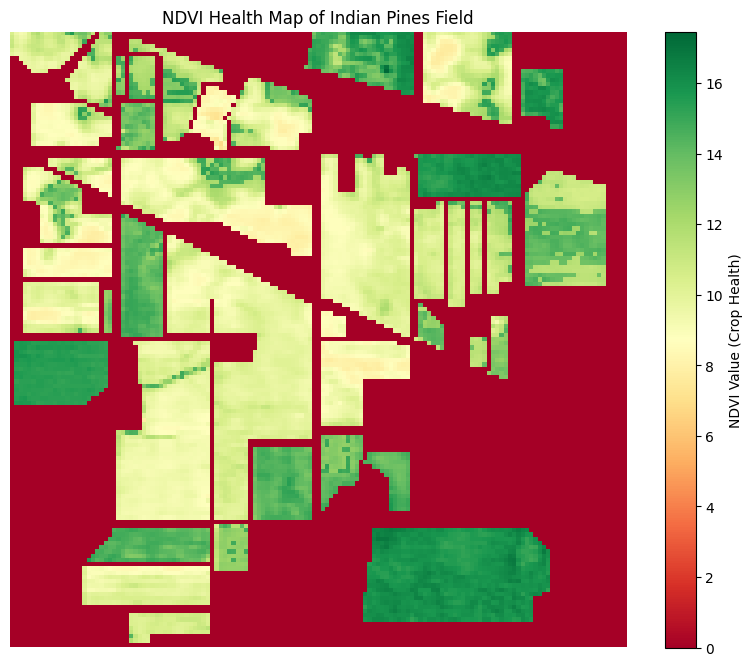


NDVI Health Map successfully generated. Red areas indicate stress; Green areas indicate high health.


In [7]:
# %%
# --- VISUALIZING CROP HEALTH: NDVI MAP ---
import matplotlib.pyplot as plt

# 1. Calculate NDVI for ALL Labeled Pixels (using the original unscaled data)
# NOTE: We use the unscaled X_final data for this calculation.
# Red Band Index: 28 (approx. 660 nm)
# NIR Band Index: 79 (approx. 850 nm)
# Assuming X_final (unscaled) is available from your earlier cells.

try:
    NIR_band_final = X_final[:, 79] 
    RED_band_final = X_final[:, 28]
except NameError:
    print("Error: X_final is not defined. Please run Code Cell 1.")
    raise

NDVI_labeled = (NIR_band_final - RED_band_final) / (NIR_band_final + RED_band_final + 1e-6)

# 2. Reconstruct the Full Image Matrix (145x145)

# Start with a blank canvas (the original image shape, 145x145)
NDVI_map = np.zeros(y.shape, dtype=float)

# Fill the labeled pixels with their calculated NDVI values
# 'labeled_samples_indices' is the index array used to filter X_final/y_final
# NOTE: We need to recreate the original indices to map back to the 145x145 grid.
# This requires accessing the global y array (original ground truth).

# Get the indices of the labeled pixels from the original flattened array
labeled_mask = (y.flatten() != 0) 

# Map the NDVI values back to the full 145x145 grid
NDVI_full_map = np.zeros_like(y, dtype=float)
NDVI_full_map[y != 0] = NDVI_labeled # Assign NDVI values only where a crop exists

# 3. Plot the NDVI Map
plt.figure(figsize=(10, 8))
# Use 'jet' or 'viridis' colormaps: high NDVI (healthy) is green/yellow, low NDVI (stressed) is red/blue
img = plt.imshow(NDVI_full_map, cmap='RdYlGn') 
plt.colorbar(img, label='NDVI Value (Crop Health)')
plt.title('NDVI Health Map of Indian Pines Field')
plt.axis('off')
plt.show()

print("\nNDVI Health Map successfully generated. Red areas indicate stress; Green areas indicate high health.")

In [8]:
# %% 
# --- SAVE TRAINED MODEL AND SCALER USING PICKLE ---
import pickle
import os

# Ensure output directory exists
OUTPUT_DIR = "outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# File paths
model_file = os.path.join(OUTPUT_DIR, "random_forest_model.pkl")
scaler_file = os.path.join(OUTPUT_DIR, "scaler.pkl")

# Save the trained Random Forest model
with open(model_file, 'wb') as f:
    pickle.dump(best_model, f)

# Save the MinMaxScaler
with open(scaler_file, 'wb') as f:
    pickle.dump(scaler, f)

print(f"Model saved at: {model_file}")
print(f"Scaler saved at: {scaler_file}")


Model saved at: outputs\random_forest_model.pkl
Scaler saved at: outputs\scaler.pkl
